{/* cspell:ignore Lipinska autoplay Tilly Ardle webkitallowfullscreen allowfullscreen frameborder referrerpolicy */}

# The ansatz

Watch as Victoria Lipinska explains what an ansatz is and why we care about it in the context of a variational quantum eigensolver (VQE).

<IBMVideo id="132414879" title="Victoria Lipinska describes the variational circuit or ansatz that we need in every VQE instance. She explains the relationship between the ansatz and the reference state, and hints at the need for a classical optimizer."/>

### References

The following articles are referenced in the above video.
* [The theory of variational hybrid quantum-classical algorithms, McClean, et al.](https://iopscience.iop.org/article/10.1088/1367-2630/18/2/023023/meta)
* [Quantum Chemistry in the Age of Quantum Computing, Cao, et al.](https://arxiv.org/pdf/1812.09976.pdf)
* [Noisy intermediate-scale quantum (NISQ) algorithms, Bharti, et al.](https://arxiv.org/pdf/2101.08448.pdf)
* [The Variational Quantum Eigensolver: A review of methods and best practices, Tilly, et al.](https://arxiv.org/abs/2111.05176)
* [Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets, Kandala, et al.](https://arxiv.org/pdf/1704.05018.pdf)
* [Quantum computational chemistry, McArdle, et al.](https://arxiv.org/pdf/1808.10402.pdf)

## Ansatz code

In the previous lesson you created a __Hamiltonian__ that describes the energy of your molecule of interest, and mapped it to a format useful for a quantum computer. The VQE uses a _variational circuit_ to prepare quantum states. We then use those states to determine the expectation value of the Hamiltonian (the energy). Parameters in the variational circuit are varied until the calculation converges on a minimum expectation value. In the quantum chemistry context, this should be the ground state energy. This lesson focuses on the variational circuit, also called the __ansatz__ (a German word meaning "approach" or "method").
In this lesson you will learn
- the set of pre-made ansaetze available in the circuit library
- How to specify or modify the features of an ansatz
- How to build your own ansatz
- examples of good and bad ansaetze

The Qiskit circuit library has many categories of circuits that can be used as an ansatz. Here, we will restrict our discussion to two-local circuits (circuits consisting of gates that act on, at most, two qubits at a time). __Efficient SU2__ is a commonly-used ansatz.

An `efficient_su_2` circuit consists of layers of single qubit operations spanned by SU(2) (special unity group of degree 2, like Pauli rotation gates) and CX entanglements. This is a heuristic pattern that can be useful in variational quantum algorithms like VQE and classification circuits in quantum machine learning (QML).

We'll start with a four-qubit example `efficient_su2` circuit with two types of SU(2) gates, say rx and ry. We also specify an entanglement scheme and the number of repetitions. If you simply `.draw()` the circuits, you will get a fairly abstract representation. A more comprehensible circuit diagram is obtained by using `.decompose().draw()`, and here we will use `output = "mpl"'.

     ┌──────────┐┌───┐     ┌──────────┐   ┌───┐                     
q_0: ┤ Rx(θ[0]) ├┤ Y ├──■──┤ Rx(θ[4]) ├───┤ Y ├─────────────────────
     ├──────────┤├───┤┌─┴─┐└──────────┘┌──┴───┴───┐   ┌───┐         
q_1: ┤ Rx(θ[1]) ├┤ Y ├┤ X ├─────■──────┤ Rx(θ[5]) ├───┤ Y ├─────────
     ├──────────┤├───┤└───┘   ┌─┴─┐    └──────────┘┌──┴───┴───┐┌───┐
q_2: ┤ Rx(θ[2]) ├┤ Y ├────────┤ X ├─────────■──────┤ Rx(θ[6]) ├┤ Y ├
     ├──────────┤├───┤        └───┘       ┌─┴─┐    ├──────────┤├───┤
q_3: ┤ Rx(θ[3]) ├┤ Y ├────────────────────┤ X ├────┤ Rx(θ[7]) ├┤ Y ├
     └──────────┘└───┘                    └───┘    └──────────┘└───┘


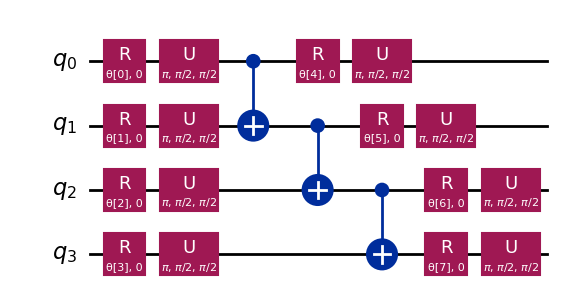

In [3]:
from qiskit.circuit.library import efficient_su2

SU2_ansatz = efficient_su2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
print(SU2_ansatz.draw())
SU2_ansatz.decompose().draw(output="mpl")

The SU(2) gates appear at the beginning and end with the order and elements as specified in su2_gates = [...]. The entanglement scheme `linear` means that the CX gates step through the numbered qubits, entangling 0 & 1, then 1 & 2, and so on, down a diagonal line in the circuit. As you might expect, setting `reps = 2` simply adds an entanglement layer and an ending SU(2) layer. Settings `reps = n` corresponds to `n` entanglement layers, with SU(2) layers between them and on each end.

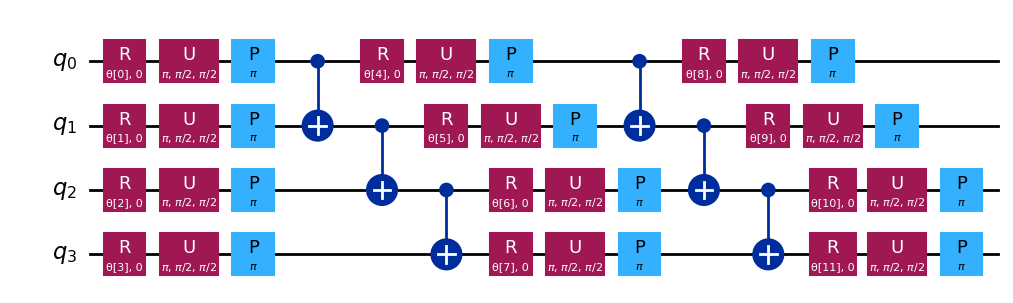

In [4]:
SU2_ansatz2 = efficient_su2(4, su2_gates=["rx", "y", "z"], entanglement="linear", reps=2)
SU2_ansatz2.decompose().draw(output="mpl")

There are several other entanglement schemes. Two worth noting are `circular` and `full`. Circular entanglement is identical to linear entanglement, but with an additional CX gate entangling the first and last qubit. The full entanglement scheme includes a CX gate between every pair of qubits. Note that for an N-qubit circuit, this is $N(N-1)/2$  $CX$ gates, and can become computationally expensive.

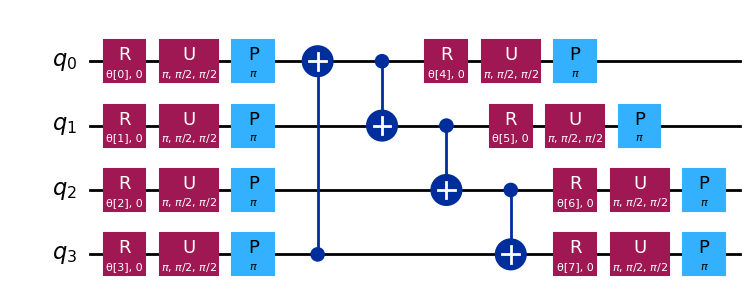

In [5]:
SU2_ansatz3 = efficient_su2(
    4, su2_gates=["rx", "y", "z"], entanglement="circular", reps=1
)
SU2_ansatz3.decompose().draw(output="mpl")

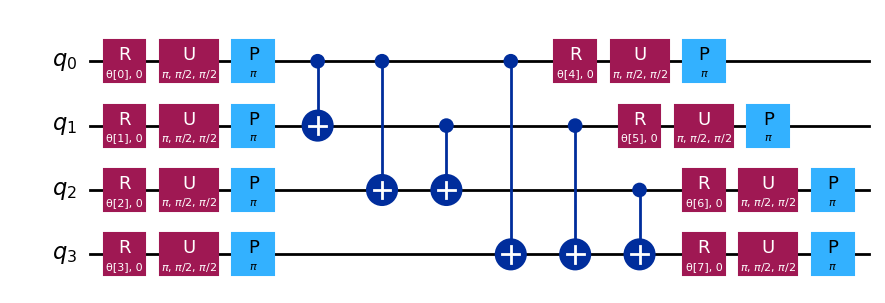

In [6]:
SU2_ansatz4 = efficient_su2(4, su2_gates=["rx", "y", "z"], entanglement="full", reps=1)
SU2_ansatz4.decompose().draw(output="mpl")

You can monitor your circuit depths by using `.depth()`, or sometimes `.decompose().depth()`.

In [8]:
print(SU2_ansatz4.decompose().depth())

11


A generalization of the efficient_su2 is the two-local circuit, which is itself a special case of the n-local circuits. The two-local circuits also contains SU(2) blocks (or rotation blocks) and entanglement blocks. Here, we are free to specify the type of entanglement gates we want to use, for example CRX gates. In this example, all gates accept a parameter, but that need not be the case. One could use Y rotation gates and CX entanglement gates, for example.

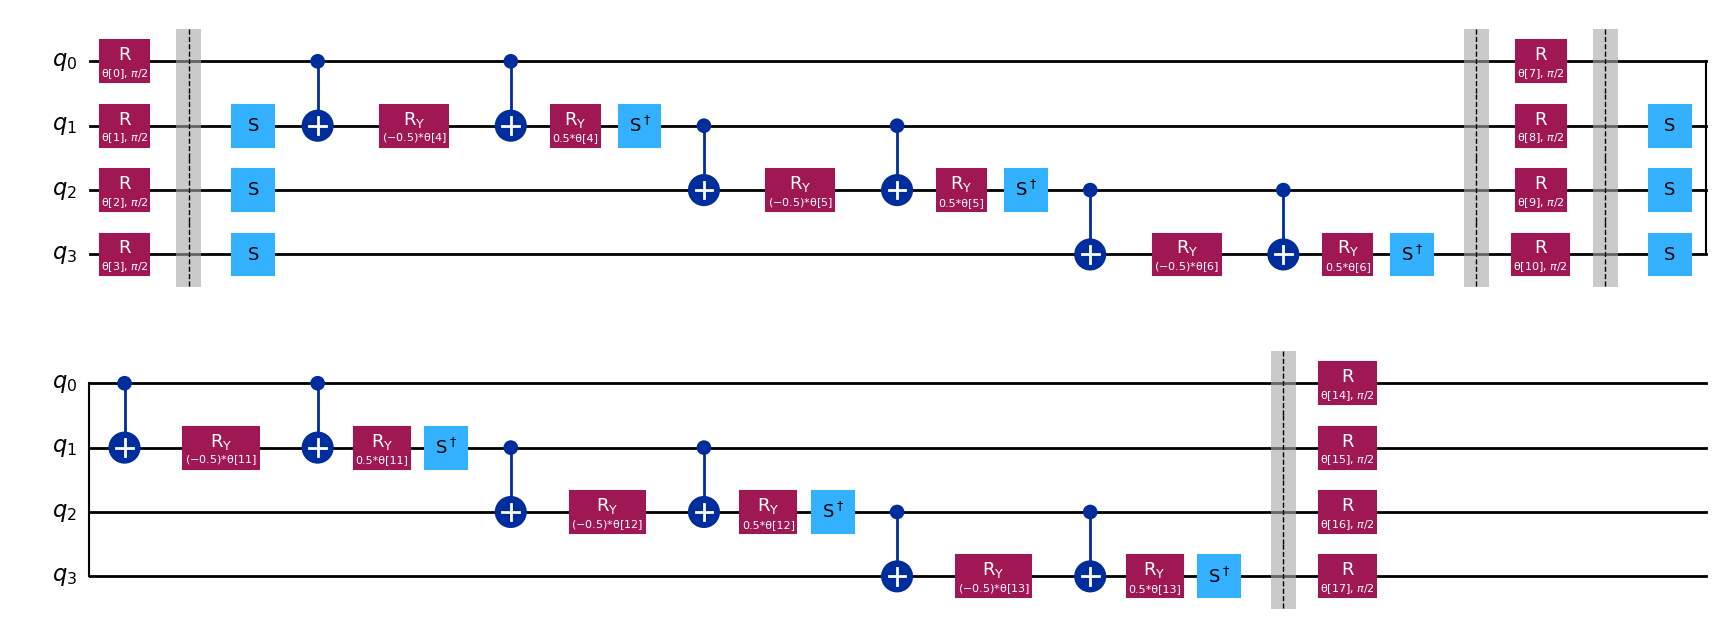

In [12]:
from qiskit.circuit.library import n_local

rotation_blocks = ["ry"]
entanglement_blocks = ["crx"]
two_ansatz = n_local(
    4, rotation_blocks, entanglement_blocks, "linear", insert_barriers=True, reps=2
)
two_ansatz.decompose().draw(output="mpl")

The last ansatz we will discuss by name is the Pauli-two-design. This circuit contains an initial rotation of $RY(pi/4)$, and rotation layers contain single qubit Pauli rotations, where the axis is chosen uniformly at random to be X, Y, or Z. The entanglement layers are composed of pairwise CZ gates with a total depth of two. Note the difference in entanglement (and total circuit) depth between this pauli_two_design and, for example, the efficient_su2.

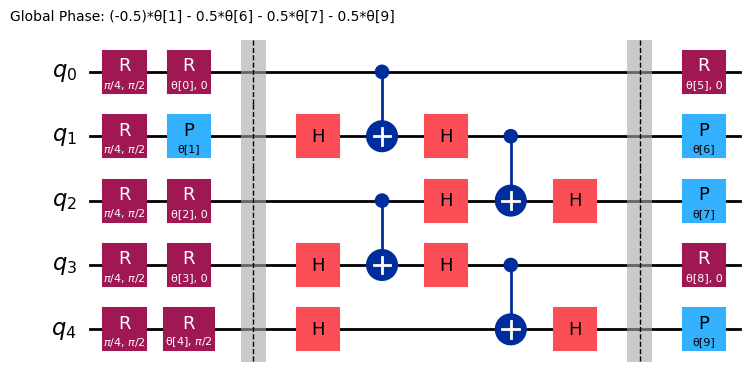

In [14]:
from qiskit.circuit.library import pauli_two_design

PtwoD_ansatz = pauli_two_design(5, reps=1, seed=10599, insert_barriers=True)
PtwoD_ansatz.decompose().draw(output="mpl")

These pre-made variational circuits are useful heuristics both in terms of achieving a desired level of entanglement and in limiting circuit depth. But there is nothing magical about them. You are free to make your own variational circuit. Indeed that may be advantageous in cases where you know something about the entanglement of the target state of your system.

To make your own ansatz, you simply construct a quantum circuit with some subset of gates being functions of elements of a parameter vector ("theta" in the three-qubit example below).

9


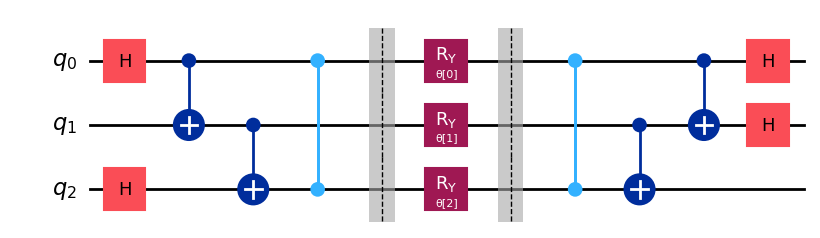

In [15]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

n = 3

theta = ParameterVector("θ", length=n)
qc = QuantumCircuit(n)
qc.h(0)
qc.h(2)
for i in range(n - 1):
    qc.cx(i, i + 1)
qc.cz(0, n - 1)
qc.barrier()
for i in range(n):
    qc.ry(theta[i], i)
qc.barrier()
qc.cz(0, n - 1)
for i in reversed(range(n - 1)):
    qc.cx(i, i + 1)
qc.h(0)
qc.h(1)
own_ansatz = qc
print(own_ansatz.depth())
qc.draw("mpl")

Generally, selecting the best ansatz is an art; the best ansatz is whatever ansatz helps you reach your target in the fewest optimization steps. It is easier to identify ansaetze that are likely to be bad. For example, greater circuit depth tends to result in accumulation of errors. Error mitigation can help with this, but it is a good practice to keep the circuit depth as low as is reasonable. But don't skip entanglement that is necessary. You might have a target state that requires a full entanglement scheme. Two examples are shown below that are likely to be poor choices for fairly obvious reasons. Choosing a good ansatz will be revisited in later sections in the context of convergence tests.

This first circuit is likely to be a poor choice because the last qubit is not entangled with the others at all. Indeed there is no computationally meaningful action on the last qubit. In all likelihood, the last qubit should either be entangled with the others or removed from the calculation.

9


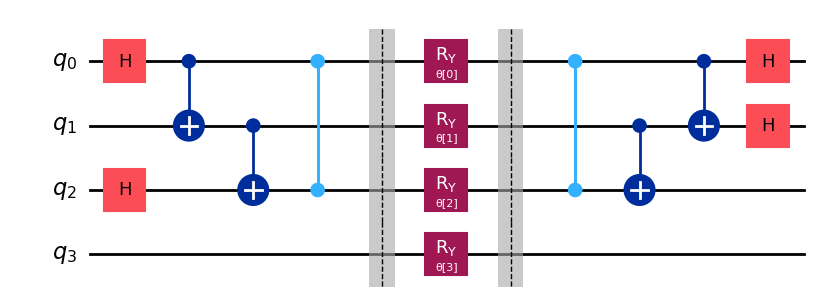

In [16]:
n = 4

theta = ParameterVector("θ", length=n)
qc = QuantumCircuit(n)
qc.h(0)
qc.h(2)
for i in range(n - 2):
    qc.cx(i, i + 1)
qc.cz(0, n - 2)
qc.barrier()
for i in range(n):
    qc.ry(theta[i], i)
qc.barrier()
qc.cz(0, n - 2)
for i in reversed(range(n - 2)):
    qc.cx(i, i + 1)
qc.h(0)
qc.h(1)
own_ansatz2 = qc
print(own_ansatz2.depth())
qc.draw("mpl")

This last circuit is likely a poor choice, because the gate depth is very high, and repeating the entanglement layer four times is not likely to yield a substantially better match to the target state than two or three repetitions.

24


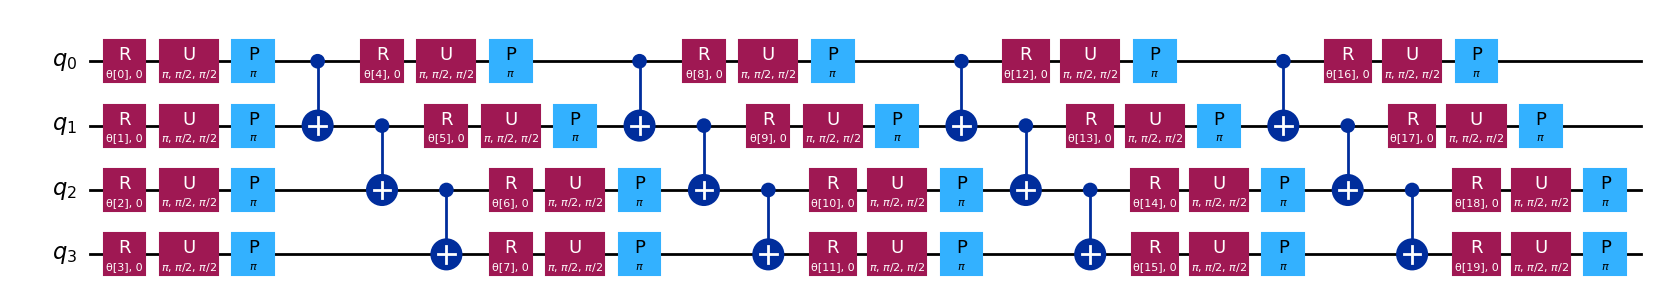

In [17]:
su2_ansatz_long = efficient_su2(
    4, su2_gates=["rx", "y", "z"], entanglement="linear", reps=4
)
print(su2_ansatz_long.decompose().depth())
su2_ansatz_long.decompose().draw(output="mpl")

These circuits are not "complete" in the sense that there are still unknown and variable parameters to be inserted into many of the gates. Those parameters are chosen by making successive guesses, and updating parameters to lower the expectation value of the cost function (in the chemistry context, typically the ground state energy). In one, or even a few dimensions, this is trivial. But the circuit above has 20 variational parameters, meaning that finding the target state with the minimal energy means searching a 20-dimensional state (another reason not to include unnecessary circuit gates). This is where classical optimizing algorithms come into play, and that is the subject of the next lesson.